In [ ]:
! pip install sentinelhub --upgrade

In [ ]:
from sentinelhub import SHConfig 
config = SHConfig()
config

SHConfig(
  instance_id='c5d989c6-c803-4876-b977-7334e176fcda',
  sh_client_id='9580129b-fb37-46ee-9d3a-4f1c326e2768',
  sh_client_secret='RX2.KbI}UdVx}l7p%;?r75zUzB[WoAzObEBM>uFM',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url='https://services.sentinel-hub.com',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1
)

Set Access credentials for the Sentinel Data


In [ ]:
# Setting up Auth
config.instance_id = '<your-instance-id>' #=> from Sentinel Hub
config.sh_client_id = '<your-client-id>'
config.sh_client_secret = '<your-secret>'

# Save the Config
config.save()

### Imports


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

# The PlotImage Function for visualizing
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# Bounding Area ==> Manhica 
# New Bounding Box 
manhica_area = [32.1902492, -25.5936676, 33.3530354, -24.6554922]

# Image Parameters
resolution = 60 
manhica_box = BBox(bbox=manhica_area, crs=CRS.WGS84)
manhica_size = bbox_to_dimensions(manhica_box, resolution=resolution)

### **Calculation of NDVI in EVALSCRIPT**

In [ ]:
evalscript_ndvi = """
  //VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B04", "B08"]
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
      return [ ndvi ]
    }
"""

request_ndvi = SentinelHubRequest(
    data_folder = 'NDVI_Images', # Saving Directly for data
    evalscript=evalscript_ndvi,
    input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A, # Consider Switching
                    time_interval=('2021-05-01', '2021-05-28'), # Set the time interval for data retrieval
                )
    ],
    responses=[
               SentinelHubRequest.output_response('default', MimeType.TIFF) #using TIFF
    ],
    bbox=manhica_box,
    size=manhica_size,
    config=config
)

In [ ]:
ndvi_img = request_ndvi.get_data()

Image Type: float32


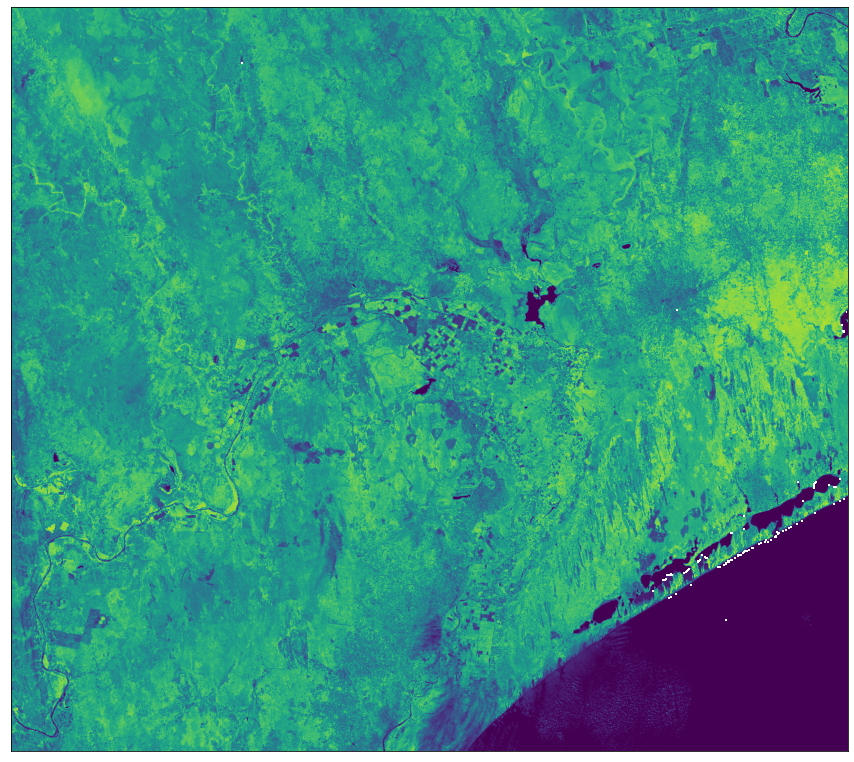

In [ ]:
image = ndvi_img[0]
print(f'Image Type: {image.dtype}')

# Plot The Image
plot_image(image, factor=3.5/255, clip_range=(0,1))

### Saving the End-Result NDVI Image File

In [ ]:
%%time
ndvi_band_img = request_ndvi.get_data(save_data=True,)

CPU times: user 221 ms, sys: 48.6 ms, total: 269 ms
Wall time: 6.03 s
